In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
from multiprocessing import Pool, cpu_count

# SABR Model Different Realisations

In [ ]:
# Graph version
@tf.function(
    input_signature=[
        tf.TensorSpec(shape=(), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.float32),
        tf.TensorSpec(shape=[None], dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32),
        tf.TensorSpec(shape=(), dtype=tf.int32),
    ],

)
def SABR_func_graph(S0, maturity, alpha0, vega, rho, strk, mcmSmpl, nStps): # Graph Execution
    """ Computes the price of an Asian call option under the SABR model.

              Args:
                S0: float, initial price
                maturity: float, maturity of the option
                alpha0: float, initial value of volatility
                vega: float, volatility of volatility
                rho: float, correlation
                strk: array(float,), strike
                mcSmpl: int, the number of Monte Carlo paths to generate
                n: int, the number of intervals on which we split [0,T]

              Returns:
                A float32 tensor

            """
    print('Tracing')

    dt = maturity/tf.cast(nStps , dtype=tf.float32 ) # time increment
    t =  tf.linspace(0.0, maturity, nStps+1) #time interval split

    # Simulating SABR volatility Wiener process
    paddings = tf.constant([[0, 0,], [1, 0]])
    vol_wnr_inc = tf.sqrt(dt)*tf.random.normal((mcmSmpl, nStps), mean=0.0, stddev=1.0, dtype=tf.float32) # wiener process icrements with W0=0
    vol_wnr_inc = tf.pad(vol_wnr_inc, paddings, "CONSTANT")
    vol_wnr_proc = tf.cumsum(vol_wnr_inc, axis=1) # Wiener process - summation is done rowise
    # Simulating SABR stock Wiener process
    und_wnr_inc = rho*vol_wnr_inc[:,1:] +  tf.sqrt(1-tf.pow(rho,2))*tf.sqrt(dt)*tf.random.normal((mcmSmpl, nStps), mean=0.0, stddev=1.0, dtype=tf.float32) # wiener process icrements with W0=0
    und_wnr_inc = tf.pad(und_wnr_inc, paddings, "CONSTANT")

    # REGULAR PATHS
    #Simulating SABR volatility path
    hlp = alpha0*tf.exp( -0.5*tf.pow(vega,2)*t )

    vol_path = hlp*tf.exp( vega*vol_wnr_proc )
    #vol_path = alpha0*tf.exp( -0.5*tf.pow(vega,2)*t + vega*vol_wnr_proc ) # Volatility path with alpha0 included
    intgr_vol_dt = dt*(tf.cumsum(tf.pow(vol_path,2),axis=1)[:,:nStps]) #Int [0,T] sigma_t**2 dt
    intgr_vol_dWt = tf.cumsum((vol_path[:,:nStps])*(und_wnr_inc[:,1:]),axis=1) #Int [0,T] sigma_t dWt

    # Simulating SABR stock path
    und_path = S0*( tf.exp( tf.pad( -0.5*intgr_vol_dt + intgr_vol_dWt, paddings, "CONSTANT")  ) )

    # ANTITHETIC PATHS
    #Simulating SABR volatility path
    vol_path_a = hlp*tf.exp(vega*(-vol_wnr_proc)) #alpha0*tf.exp( -0.5*tf.pow(vega,2)*t + vega*(-vol_wnr_proc) ) # Volatility path with alpha0 included
    intgr_vol_dt_a = dt*(tf.cumsum(tf.pow(vol_path_a,2),axis=1)[:,:nStps]) #Int [0,T] sigma_t**2 dt
    intgr_vol_dWt_a = tf.cumsum((vol_path_a[:,:nStps])*(-und_wnr_inc[:,1:]),axis=1) #Int [0,T] sigma_t dWt

    # Simulating SABR stock path
    und_path_a = S0*( tf.exp( tf.pad( -0.5*intgr_vol_dt_a + intgr_vol_dWt_a, paddings, "CONSTANT")  ) )

    #del vol_wnr_proc, vol_wnr_inc, und_wnr_inc # This line slows down a code.

    new_strike = tf.reshape( strk, [-1,1]) # Reshape strike to [[K1],[K2],...]
    price_lst_mc = (tf.maximum(tf.math.reduce_mean(und_path,axis=1)-new_strike,0)+tf.maximum(tf.math.reduce_mean(und_path_a,axis=1)-new_strike,0))/2
    price = tf.math.reduce_mean( price_lst_mc, axis=1  )

    return  price

In [ ]:
# The same as above just without decorator @tf.function
def SABR_func_eager(S0, maturity, alpha0, vega, rho, strk, mcmSmpl, nStps): # Eager Execution
    """ Computes the price of an Asian call option under the SABR model.

      Args:
        params: A float32 tensor at which the density is to be computed.
        mcmSmpl: int, the number of Monte Carlo samples.
        nStps: int, the number of discretization steps of the [0,T] interval.
        strk: A list with strikes of arbitrary type.

      Returns:
        A float32 tensor of the normal density evaluated at the supplied points.

    """
    #print('Tracing')

    dt = maturity/tf.cast(nStps , dtype=tf.float32 ) # time increment
    t =  tf.linspace(0.0, maturity, nStps+1) #time interval split

    # Simulating SABR volatility Wiener process
    paddings = tf.constant([[0, 0,], [1, 0]])
    vol_wnr_inc = tf.sqrt(dt)*tf.random.normal((mcmSmpl, nStps), mean=0.0, stddev=1.0, dtype=tf.float32) # wiener process icrements with W0=0
    vol_wnr_inc = tf.pad(vol_wnr_inc, paddings, "CONSTANT")
    vol_wnr_proc = tf.cumsum(vol_wnr_inc, axis=1) # Wiener process - summation is done rowise
    # Simulating SABR stock Wiener process
    und_wnr_inc = rho*vol_wnr_inc[:,1:] +  tf.sqrt(1-tf.pow(rho,2))*tf.sqrt(dt)*tf.random.normal((mcmSmpl, nStps), mean=0.0, stddev=1.0, dtype=tf.float32) # wiener process icrements with W0=0
    und_wnr_inc = tf.pad(und_wnr_inc, paddings, "CONSTANT")

    # REGULAR PATHS
    #Simulating SABR volatility path
    hlp = alpha0*tf.exp( -0.5*tf.pow(vega,2)*t )

    vol_path = hlp*tf.exp( vega*vol_wnr_proc )
    #vol_path = alpha0*tf.exp( -0.5*tf.pow(vega,2)*t + vega*vol_wnr_proc ) # Volatility path with alpha0 included
    intgr_vol_dt = dt*(tf.cumsum(tf.pow(vol_path,2),axis=1)[:,:nStps]) #Int [0,T] sigma_t**2 dt
    intgr_vol_dWt = tf.cumsum((vol_path[:,:nStps])*(und_wnr_inc[:,1:]),axis=1) #Int [0,T] sigma_t dWt

    # Simulating SABR stock path
    und_path = S0*( tf.exp( tf.pad( -0.5*intgr_vol_dt + intgr_vol_dWt, paddings, "CONSTANT")  ) )

    # ANTITHETIC PATHS
    #Simulating SABR volatility path
    vol_path_a = hlp*tf.exp(vega*(-vol_wnr_proc)) # alpha0*tf.exp( -0.5*tf.pow(vega,2)*t + vega*(-vol_wnr_proc) ) # Volatility path with alpha0 included
    intgr_vol_dt_a = dt*(tf.cumsum(tf.pow(vol_path_a,2),axis=1)[:,:nStps]) #Int [0,T] sigma_t**2 dt
    intgr_vol_dWt_a = tf.cumsum((vol_path_a[:,:nStps])*(-und_wnr_inc[:,1:]),axis=1) #Int [0,T] sigma_t dWt

    # Simulating SABR stock path
    und_path_a = S0*( tf.exp( tf.pad( -0.5*intgr_vol_dt_a + intgr_vol_dWt_a, paddings, "CONSTANT")  ) )

    #del vol_wnr_proc, vol_wnr_inc, und_wnr_inc # This line slows down a code.

    new_strike = tf.reshape( strk, [-1,1]) # Reshape strike to [[K1],[K2],...]
    price_lst_mc = (tf.maximum(tf.math.reduce_mean(und_path,axis=1)-new_strike,0)+tf.maximum(tf.math.reduce_mean(und_path_a,axis=1)-new_strike,0))/2
    price = tf.math.reduce_mean( price_lst_mc, axis=1  )

    return  price

In [ ]:
def SABR_func_numpy(alpha0, vega, rho, S0, T, strk, mcSmpl, n):
    """Generates price of an Asian Call option.

          Args:
            alpha0: float, initial value of volatility
            vega: float, volatility of volatility
            rho: float, correlation
            S0: float, initial price
            T: float, maturity of the option
            strk: array(float,), strike
            mcSmpl: int, the number of Monte Carlo paths to generate
            n: int, the number of intervals on which we split [0,T]

          Returns:
            array of floats of dimension len(strk).
            """

    # initialise simulation params
    dt = T/n
    t = np.linspace(0, T, n+1)


    # simulating Wiener Processes
    vol_wnr_inc = np.zeros((mcSmpl,n+1)) # preallocate variable (1st elem will correspond to sigma0)
    vol_wnr_inc[:,1:] = np.sqrt(dt)*np.random.normal(size = (mcSmpl, n)) # wiener process increments
    vol_wnr_proc = np.cumsum(vol_wnr_inc, axis=1) # Wiener process. Summation in each subelement of wnr_inc (by row)

    undr_wnr_inc = np.zeros((mcSmpl,n+1)) # preallocate variable (1st elem will correspond to S0)
    #z = np.random.normal(size = (mcSmpl, n))
    undr_wnr_inc[:,1:] = rho*vol_wnr_inc[:,1:] + np.sqrt(1-rho**2)*np.sqrt(dt)*np.random.normal(size = (mcSmpl, n)) # Correlated

    # Paths
    hlp = alpha0*np.exp(-0.5*(vega**2)*t)
    path_vol =  hlp*np.exp(vega*vol_wnr_proc) #alpha0*np.exp( -0.5*(vega**2)*t + vega*vol_wnr_proc )
    intgr_vol_dt = dt*(np.cumsum(path_vol**2,axis=1)[:,:n])
    intgr_vol_dWt = np.cumsum((path_vol[:,:n])*(undr_wnr_inc[:,1:]),axis=1)

    path_undr = np.zeros((mcSmpl,n+1))
    path_undr[:,0] = S0
    path_undr[:,1:] = S0*np.exp( -0.5*intgr_vol_dt + intgr_vol_dWt )

    # Antithetic Path
    #vol_wnr_proc = np.cumsum(-vol_wnr_inc, axis=1) # Wiener process. Summation in each subelement of wnr_inc (by row)

    path_vol =  hlp*np.exp(vega*(-vol_wnr_proc)) #alpha0*np.exp( -0.5*(vega**2)*t + vega*(-vol_wnr_proc) )
    intgr_vol_dt = dt*(np.cumsum(path_vol**2,axis=1)[:,:n])
    intgr_vol_dWt = np.cumsum((path_vol[:,:n])*(-undr_wnr_inc[:,1:]),axis=1)

    path_undr_a = np.zeros((mcSmpl,n+1))
    path_undr_a[:,0] = S0
    path_undr_a[:,1:] = S0*np.exp( -0.5*intgr_vol_dt + intgr_vol_dWt )

    new_strike = np.reshape(strk, [-1,1]) # Reshape strike to [[K1],[K2],...]
    final_price = np.mean( (np.maximum(np.mean(path_undr,axis=1)-new_strike,0)+np.maximum(np.mean(path_undr_a,axis=1)-new_strike,0))/2, axis=1)

    return final_price

In [ ]:
# WARM UP for TRACING
SABR_func_graph(S0=100., maturity=0.5, alpha0=0.3, vega=0.5, rho=-0.3, strk=tf.convert_to_tensor([100.,105.], dtype=tf.float32), mcmSmpl=100, nStps=50)

Tracing


<tf.Tensor: shape=(2,), dtype=float32, numpy=array([4.9686403, 2.8433027], dtype=float32)>

In [ ]:
#SABR_func_eager(S0=100., maturity=0.5, alpha0=0.3, vega=0.5, rho=-0.3, strk=tf.convert_to_tensor([100.,105.], dtype=tf.float32), mcmSmpl=500000, nStps=50)

In [ ]:
#SABR_func_numpy(S0=100., T=0.5, alpha0=0.3, vega=0.5, rho=-0.3, strk=np.array([100.,105.]), n=500000, mcSmpl=50)

# Numerical Comparison

## As a function of Monte Carlo samples

### CPU Run

In [ ]:
S0=100.
strike = np.arange(90,110,1)
maturity=1/12
alpha0=0.3
vega=0.5
rho=-0.3
nStps=30

rng = [250000, 500000, 750000, 1000000, 1500000]

In [ ]:
# Tensor Flow Graph mode
time_result_graph = []

for i in rng:
  interm_time = []
  for j in range(10):
    start_time = time.time()
    price_proc= SABR_func_graph(S0, maturity, alpha0, vega, rho, tf.convert_to_tensor(strike, dtype=tf.float32), i, nStps)
    end_time = time.time()
    interm_time.append((end_time - start_time))
  time_result_graph.append(interm_time)

np.median(time_result_graph,axis=1)

array([0.87567043, 1.79196405, 3.09502745, 4.19254827, 8.08946157])

In [ ]:
# Tensor Flow Eager mode
time_result_eager = []
for i in rng:
  interm_time = []
  for j in range(10):
    start_time = time.time()
    price_proc= SABR_func_eager(S0, maturity, alpha0, vega, rho, tf.convert_to_tensor(strike, dtype=tf.float32), i, nStps)
    end_time = time.time()
    interm_time.append((end_time - start_time))
  time_result_eager.append(interm_time)

np.median(time_result_eager,axis=1)

array([ 1.34752381,  3.13124692,  5.13795769,  8.36981273, 11.57027161])

In [ ]:
# NumPy
time_result_numpy = []
for i in rng:
  interm_time = []
  for j in range(10):
    start_time = time.time()
    price_proc = SABR_func_numpy(alpha0, vega, rho, S0, maturity, strike, i, nStps)
    end_time = time.time()
    interm_time.append((end_time - start_time))
  time_result_numpy.append(interm_time)

np.median(time_result_numpy,axis=1)

array([ 1.62065446,  3.33186078,  5.05895722,  7.6970824 , 11.0308398 ])

In [ ]:
time_result_numpy = [ 1.62065446,  3.33186078,  5.05895722,  7.6970824 , 11.0308398 ]
time_result_eager = [ 1.34752381,  3.13124692,  5.13795769,  8.36981273, 11.57027161]
time_result_graph = [0.87567043, 1.79196405, 3.09502745, 4.19254827, 8.08946157]

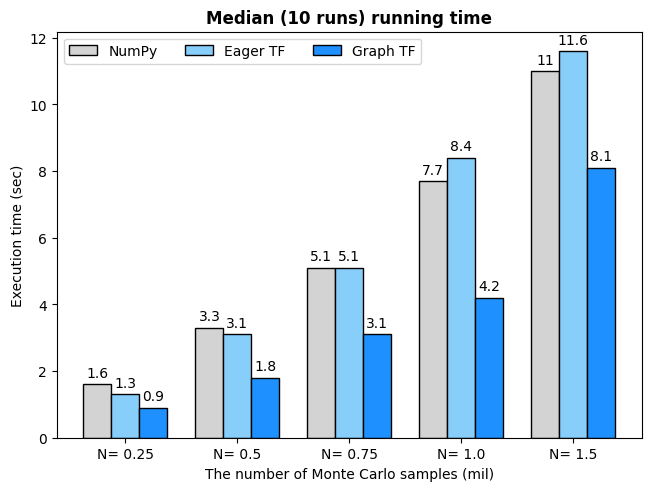

In [ ]:
n_size = list(map(lambda x: 'N= '+str(x/1000000), rng))
results = {
    'NumPy': np.round(time_result_numpy,1),
    'Eager TF': np.round(time_result_eager,1),
    'Graph TF': np.round(time_result_graph,1),
}

x = np.arange(len(n_size))
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')
col_dict={'NumPy':'lightgrey','Eager TF':'lightskyblue','Graph TF':'dodgerblue'}
for attribute, measurement in results.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width,color=col_dict[attribute],edgecolor='black', label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Execution time (sec)')
ax.set_xlabel('The number of Monte Carlo samples (mil)')
ax.set_title('Median (10 runs) running time', fontweight='bold')
ax.set_xticks(x + width, n_size)
ax.legend(loc='upper left', ncols=3)
#ax.set_ylim(0, 250)

plt.show()

### GPU Run

In [ ]:
S0=100.
strike = np.arange(90,110,1)
maturity=1/12
alpha0=0.3
vega=0.5
rho=-0.3
nStps=30

rng = [250000, 500000, 750000, 1000000, 1500000]

In [ ]:
# Tensor Flow Graph mode
time_result_graph = []

for i in rng:
  interm_time = []
  for j in range(10):
    start_time = time.time()
    price_proc= SABR_func_graph(S0, maturity, alpha0, vega, rho, tf.convert_to_tensor(strike, dtype=tf.float32), i, nStps)
    end_time = time.time()
    interm_time.append((end_time - start_time))
  time_result_graph.append(interm_time)

np.median(time_result_graph,axis=1)

array([0.02345419, 0.03447056, 0.05181527, 0.06980252, 0.10172629])

In [ ]:
# Tensor Flow Eager mode
time_result_eager = []
for i in rng:
  interm_time = []
  for j in range(10):
    start_time = time.time()
    price_proc= SABR_func_eager(S0, maturity, alpha0, vega, rho, tf.convert_to_tensor(strike, dtype=tf.float32), i, nStps)
    end_time = time.time()
    interm_time.append((end_time - start_time))
  time_result_eager.append(interm_time)

np.median(time_result_eager,axis=1)

array([0.024207  , 0.04206049, 0.06225169, 0.08187556, 0.11955762])

In [ ]:
time_result_eager_gpu = [0.024207  , 0.04206049, 0.06225169, 0.08187556, 0.11955762]
time_result_graph_gpu = [0.02345419, 0.03447056, 0.05181527, 0.06980252, 0.10172629]

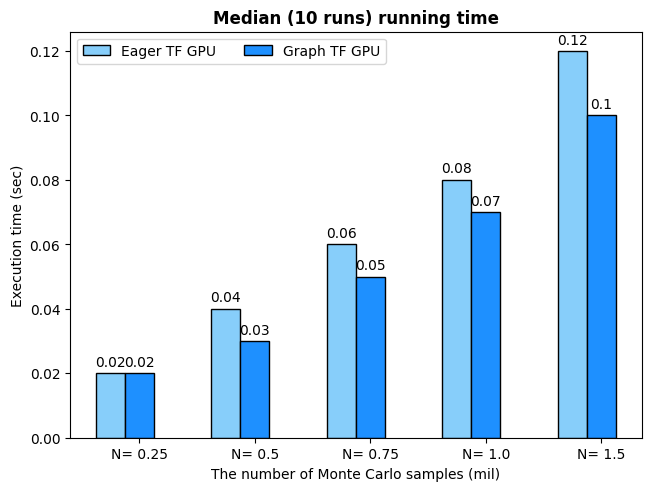

In [ ]:
n_size = list(map(lambda x: 'N= '+str(x/1000000), rng))
results = {
    'Eager TF GPU': np.round(time_result_eager_gpu,2),
    'Graph TF GPU': np.round(time_result_graph_gpu,2),
}

x = np.arange(len(n_size))
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')
col_dict={'Eager TF GPU':'lightskyblue','Graph TF GPU':'dodgerblue'}
for attribute, measurement in results.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, color=col_dict[attribute],edgecolor='black',label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Execution time (sec)')
ax.set_xlabel('The number of Monte Carlo samples (mil)')
ax.set_title('Median (10 runs) running time', fontweight='bold')
ax.set_xticks(x + width, n_size)
ax.legend(loc='upper left', ncols=2)
#ax.set_ylim(0, 250)

plt.show()

## As a function of parameter samples

In [ ]:
def sabr_params_gen(sigma0_min, sigma0_max, volvol_min, volvol_max, rho_min, rho_max, n_samples):

  sigma_0 = np.random.uniform(sigma0_min,sigma0_max,n_samples)
  volvol = np.random.uniform(volvol_min,volvol_max,n_samples)
  rho = np.random.uniform(rho_min,rho_max,n_samples)

  res = np.concatenate((sigma_0.reshape(n_samples,1), volvol.reshape(n_samples,1), rho.reshape(n_samples,1)), axis=1)

  return  res

In [ ]:
S0=100.
strike = np.array(np.arange(90.,110.,1.))
maturity=1/12
alpha0=0.3
vega=0.5
rho=-0.3
nStps=30
mcmSmpl=500000

rng = [10,30,50,100]

In [ ]:
# Graph Mode
time_result_graph = []
for i in rng:
  print('Batch',i)
  params = sabr_params_gen(sigma0_min=0.2, sigma0_max=0.8, volvol_min=0.3, volvol_max=1.5, rho_min=-0.9, rho_max=0.9, n_samples=i)
  start_time = time.time()

  [SABR_func_graph(S0, maturity, x[0], x[1], x[2], tf.convert_to_tensor(strike, dtype=tf.float32), mcmSmpl, nStps) for x in params]

  end_time = time.time()
  time_result_graph.append(end_time - start_time)

time_result_graph

Batch 10
Batch 30
Batch 50
Batch 100


[26.0440456867218, 110.66869854927063, 164.63927674293518, 265.7270715236664]

In [ ]:
# PARALLEL Graph Mode
time_result_graph_parallel = []
for i in rng:
  print('Batch',i)
  params = sabr_params_gen(sigma0_min=0.2, sigma0_max=0.8, volvol_min=0.3, volvol_max=1.5, rho_min=-0.9, rho_max=0.9, n_samples=i)
  start_time = time.time()

  tf.map_fn(fn=lambda x: SABR_func_graph(S0, maturity, x[0], x[1], x[2], tf.convert_to_tensor(strike, dtype=tf.float32), mcmSmpl, nStps) , elems=tf.constant(params,tf.float32), parallel_iterations=10);

  end_time = time.time()
  time_result_graph_parallel.append(end_time - start_time)

time_result_graph_parallel

Batch 10
Batch 30
Batch 50
Batch 100


[24.86713743209839, 71.00004982948303, 122.06665468215942, 240.18021368980408]

In [ ]:
# Regular NumPy
time_result_numpy = []
for i in rng:
  print('Batch',i)
  params = sabr_params_gen(sigma0_min=0.2, sigma0_max=0.8, volvol_min=0.3, volvol_max=1.5, rho_min=-0.9, rho_max=0.9, n_samples=i)
  start_time = time.time()

  [SABR_func_numpy(x[0],x[1],x[2], S0, maturity, strike, mcmSmpl, nStps) for x in params]

  end_time = time.time()
  time_result_numpy.append(end_time - start_time)

time_result_numpy

Batch 10
Batch 30
Batch 50
Batch 100


[34.474692821502686, 105.39584374427795, 176.86913561820984, 369.7765839099884]

In [ ]:
# Parallel NumPy
time_result_numpy_parallel = []
for i in rng:
  print('Batch', i)
  ds = sabr_params_gen(sigma0_min=0.2, sigma0_max=0.8, volvol_min=0.3, volvol_max=1.5, rho_min=-0.9, rho_max=0.9, n_samples=i)
  ds = list( map( lambda x: np.append(x,np.array([S0,maturity,strike,mcmSmpl,nStps],dtype=object)), ds) )
  pool = Pool(processes = cpu_count())
  start_time = time.time()

  result = pool.starmap(SABR_func_numpy, ds )

  end_time = time.time()
  pool.close()
  pool.join()
  time_result_numpy_parallel.append(end_time - start_time)

time_result_numpy_parallel

Batch 10
Batch 30
Batch 50
Batch 100


[29.526238679885864, 88.24899744987488, 144.98493361473083, 285.41661739349365]

In [ ]:
# Graph Mode GPU RUN
time_result_graph_gpu = []
for i in rng:
  print('Batch',i)
  params = sabr_params_gen(sigma0_min=0.2, sigma0_max=0.8, volvol_min=0.3, volvol_max=1.5, rho_min=-0.9, rho_max=0.9, n_samples=i)
  start_time = time.time()

  [SABR_func_graph(S0, maturity, x[0], x[1], x[2], tf.convert_to_tensor(strike, dtype=tf.float32), mcmSmpl, nStps) for x in params]

  end_time = time.time()
  time_result_graph_gpu.append(end_time - start_time)

time_result_graph_gpu

Batch 10
Batch 30
Batch 50
Batch 100


[0.4846475124359131,
 1.0532121658325195,
 1.8414995670318604,
 3.6313071250915527]

In [ ]:
time_result_numpy = [34.474692821502686, 105.39584374427795, 176.86913561820984, 369.7765839099884]
time_result_numpy_parallel = [29.526238679885864, 88.24899744987488, 144.98493361473083, 285.41661739349365]
time_result_graph = [26.0440456867218, 110.66869854927063, 164.63927674293518, 265.7270715236664]
time_result_graph_parallel = [24.86713743209839, 71.00004982948303, 122.06665468215942, 240.18021368980408]
time_result_graph_gpu = [0.4846475124359131, 1.0532121658325195, 1.8414995670318604, 3.6313071250915527]

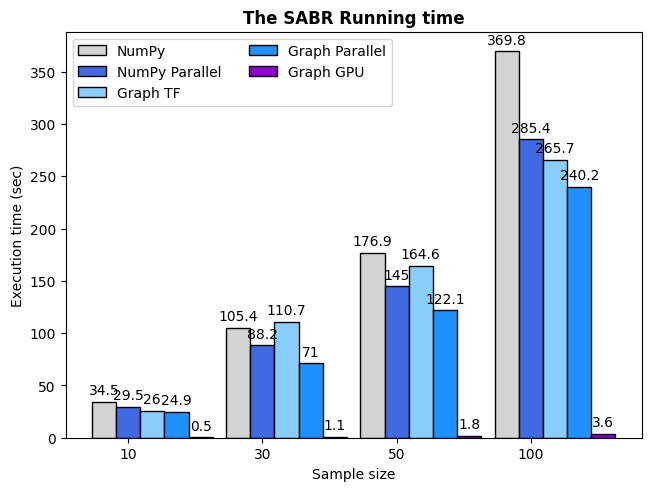

In [ ]:
n_size = list(map(lambda x: str(x), rng))
results = {
    'NumPy': np.round(time_result_numpy,1),
    'NumPy Parallel': np.round(time_result_numpy_parallel,1),
    'Graph TF': np.round(time_result_graph,1),
    'Graph Parallel': np.round(time_result_graph_parallel,1),
    'Graph GPU': np.round(time_result_graph_gpu,1),
    #'Graph GPU XLA': np.round(time_result_graph_xla,1)
}

x = np.arange(len(n_size))
width = 0.18  # the width of the bars
multiplier = 0
col_dict={'NumPy':'lightgrey','NumPy Parallel':'royalblue', 'Graph TF':'lightskyblue','Graph Parallel':'dodgerblue','Graph GPU':'darkviolet'}
fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in results.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, color=col_dict[attribute], edgecolor='black', label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Execution time (sec)')
ax.set_xlabel('Sample size')
ax.set_title('The SABR Running time', fontweight='bold')
ax.set_xticks(x + width, n_size)
ax.legend(loc='upper left', ncols=2)

plt.show()